In [5]:
import sys; sys.path.append('../3rdparty/ElasticRods/python')
import elastic_rods, elastic_knots
import numpy as np, matplotlib.pyplot as plt, time, io, os
from helpers import *
from parametric_curves import *
import py_newton_optimizer

from linkage_vis import LinkageViewer as Viewer, CenterlineViewer
from tri_mesh_viewer import PointCloudViewer, PointCloudMesh

%load_ext autoreload
%autoreload 2

import parallelism
parallelism.set_max_num_tbb_threads(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def callback(problem, iteration):
    if iteration % 5 == 0:
        view.update()
        
optimizerOptions = py_newton_optimizer.NewtonOptimizerOptions()
optimizerOptions.niter = 100
optimizerOptions.gradTol = 1e-8
hessianShift = 1e-4 * compute_min_eigenval_straight_rod(pr)

problemOptions = elastic_knots.ContactProblemOptions()
problemOptions.contactStiffness = 1e3
problemOptions.dHat = 2*rod_radius

fixedVars = []   # all the degrees of freedom can be modified by the optimizer

In [17]:
# Optimize
def optimize():
    report = elastic_knots.compute_equilibrium(
        rod_list, problemOptions, optimizerOptions, 
        fixedVars=fixedVars,
        externalForces=np.zeros(rod_list.numDoF()),
        softConstraints=[],
        callback=callback,
        hessianShift=hessianShift
        )
    view.update()

In [18]:
def move_linear(rods, target,steps=100):
    diff = rods.getDoFs()[:1200] - target
    DoFs = rods.getDoFs()
    path = [DoFs.copy()]
    for i in range(int(steps)):
        DoFs[:1200] -= 1/steps *diff
        rods.setDoFs(DoFs)
        path.append(DoFs.copy())
        view.update()
    return path

In [19]:
file = '../data/L400-r0.2-UpTo9Crossings/4_1/0033.obj'
rod_radius = 0.2
material = elastic_rods.RodMaterial('ellipse', 2000, 0.3, [rod_radius, rod_radius])
centerline = read_nodes_from_file(file)  # supported formats: obj, txt
pr = define_periodic_rod(centerline, material)
rod_list = elastic_knots.PeriodicRodList([pr])

In [20]:
# Optimize
def optimize():
    report = elastic_knots.compute_equilibrium(
        rod_list, problemOptions, optimizerOptions, 
        fixedVars=fixedVars,
        externalForces=np.zeros(rod_list.numDoF()),
        softConstraints=[],
        callback=callback,
        hessianShift=hessianShift
        )
    view.update()

In [21]:
view = Viewer(rod_list, width=1024, height=800)
view.show()

Renderer(camera=PerspectiveCamera(aspect=1.28, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0),…

In [22]:
file = '../data/L400-r0.2-UpTo9Crossings/4_1/0001.obj'
nodes = read_nodes_from_file(file).flatten()
path = move_linear(rod_list,nodes,steps=100)

In [23]:
def getPathEnergy(path, rod_list, view):
    path_energy=[]
    for DoFs in path:
        rod_list.setDoFs(DoFs)
        path_energy.append(rod_list.energy())
        view.update()
    return path_energy

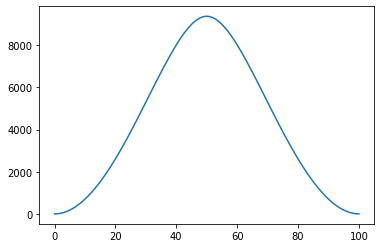

Path energy: 426620.5719599152


In [24]:
path_energy = getPathEnergy(path,rod_list,view)
plt.plot(range(len(path_energy)),path_energy)
plt.show()
print(f"Path energy: {sum(path_energy)}")

In [25]:
def show_path(rod_list, path, view, wait=0.1):
    for DoFs in path:
        rod_list.setDoFs(DoFs)
        time.sleep(wait)
        view.update()
        

In [42]:
time.sleep(3)
show_path(rod_list,path, view)